In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

In [2]:
df = pd.read_csv('ready_data.csv', index_col='date', parse_dates=True)
df.head()

,bhp,bht,dp_tubing,thp,tht,choke_size_percentage,QL,QG
date,,,,,,,,
2008-02-14,295.586061,105.775486,181.867887,113.718175,72.737631,80.120465,3333.600000,543951.872000
2008-02-15,297.662702,105.751875,180.832060,116.830642,69.995943,84.250990,2705.053996,397504.971058
2008-02-16,295.935519,105.811114,180.501045,115.434474,71.518347,82.359026,3056.690000,418474.000000
2008-02-17,295.551657,105.831299,180.345781,115.205876,73.641800,82.168501,2984.480000,422763.000000
2008-02-18,294.211063,105.866467,180.929248,113.281815,74.160157,80.263045,3116.869565,431823.652174


In [3]:
def iqr_outliers(data, p):
    q1, q3 = np.percentile(data, [25, 75])
    
    IQR = q3 - q1
    
    lower_fence = q1 - (p * IQR)
    upper_fence = q3 + (p * IQR)
 
    for i in range(len(data.values)):
        if data[i] > upper_fence or data[i] < lower_fence:
            data[i] = np.nan

    return data

In [4]:
df['bht'] = iqr_outliers(df['bht'], 1.5)
df['bht'] = df['bht'].interpolate(method='linear')

In [5]:
last_lday , last_2day = df.shift(+1), df.shift(+2)

last_lday.rename(columns={
        'bhp' : '1last_bhp',
        'bht' : '1last_bht',
        'dp_tubing' : '1last_dp_tubing',
        'AVG_CHOKE_SIZE_P' : '1last_AVG_CHOKE_SIZE_P',
        'thp' : '1last_thp',
        'tht' : "1last_tht",
        "choke_size_percentage" : "1last_choke_size_percentage",
        "QL" : "1last_QL",
        "QG" : "1last_QG"
}, inplace=True)

last_2day.rename(columns={
        'bhp' : '2last_bhp',
        'bht' : '2last_bht',
        'dp_tubing' : '2last_dp_tubing',
        'AVG_CHOKE_SIZE_P' : '2last_AVG_CHOKE_SIZE_P',
        'thp' : '2last_thp',
        'tht' : "2last_tht",
        "choke_size_percentage" : "2last_choke_size_percentage",
        "QL" : "2last_QL",
        "QG" : "2last_QG"
    }, inplace=True)

well = pd.concat([df, last_lday, last_2day], axis=1)
well.dropna(inplace=True)
well.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3052 entries, 2008-02-16 to 2016-09-17
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   bhp                          3052 non-null   float64
 1   bht                          3052 non-null   float64
 2   dp_tubing                    3052 non-null   float64
 3   thp                          3052 non-null   float64
 4   tht                          3052 non-null   float64
 5   choke_size_percentage        3052 non-null   float64
 6   QL                           3052 non-null   float64
 7   QG                           3052 non-null   float64
 8   1last_bhp                    3052 non-null   float64
 9   1last_bht                    3052 non-null   float64
 10  1last_dp_tubing              3052 non-null   float64
 11  1last_thp                    3052 non-null   float64
 12  1last_tht                    3052 non-null   float64
 13  

In [6]:
X = well.drop(['QL', 'QG'], axis=1)
y = well['QL']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [9]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
xg_reg = xgb.XGBRegressor(verbosity=3)

param_grid = { 
    'colsample_bytre': [0.000001, 0.000005, 0.00001,0.00005,0.0001],
    'learning_rate': [0.2, 0.3, 0.35,0.4,0.45],
    'max_depth' : [1],
    'n_estimators' :[10000, 1500, 1800,2000]
}

CV_rfc = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv= 5,n_jobs=-1)
CV_rfc.fit(X_train, y_train)

In [22]:
CV_rfc.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [15]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [16]:
y_p = xgb_reg.predict(X_test)

In [17]:
from sklearn.metrics import r2_score, mean_absolute_error
print(r2_score(y_test, y_p))
print(mean_absolute_error(y_test, y_p))

0.9395619374856836
197.46989440290207


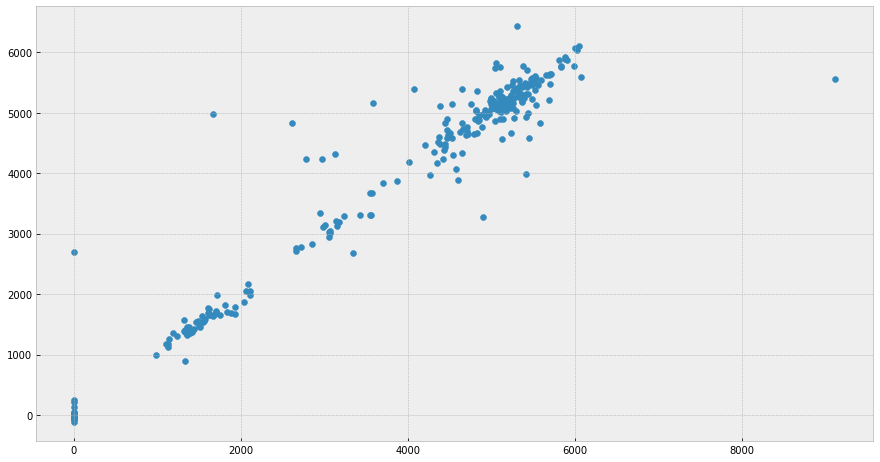

In [19]:
plt.figure(figsize=(15, 8))
plt.scatter(y_test, y_p)

In [ ]:
blind_df = pd.DataFrame()
blind_df['y_pred'] = y_pred
blind_df['y_b'] = y_b.values

In [ ]:
sns.set_theme(style="darkgrid")

g = sns.jointplot(x="y_b", y="y_pred", data=blind_df,
                  kind="reg", truncate=False,
                 
                  color="m", height=7)

In [ ]:
plt.figure(figsize=(15, 8))
plt.bar(range(len(xg_reg.feature_importances_)), xg_reg.feature_importances_)
plt.show()

In [ ]:
print(xg_reg.feature_importances_)